# Space Weather Forecast Notebook

This notebook is used for debugging and experimenting with the PatchTST model for forecasting space weather indices (ap_index_nT and f10.7_index).

We will load and preprocess the data, define our model and dataset, and then run training and evaluation functions. Use the controls below to run or skip certain sections (e.g., if you only want to debug data preprocessing).


In [ ]:
import argparse
import logging
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
from tqdm import tqdm  # Make sure you have tqdm installed
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up logging with a default INFO level.
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger(__name__)

# For notebook usage, you might want to display plots inline.
%matplotlib inline


## 1. Define the PatchTST-inspired Model

The model takes a time series input, "patchifies" it using a 1D convolution, passes it through Transformer encoder layers, and finally outputs a forecast for the target features. We set `batch_first=True` to simplify the input shapes.


In [8]:
class PatchTST(nn.Module):
    """
    A simplified PatchTST model.
    This model "patchifies" the input time series with a 1D convolution,
    processes the patches with Transformer encoder layers, and then outputs
    a forecast for a fixed horizon.
    """
    def __init__(self, input_size, patch_size, d_model, n_heads, n_layers, 
                 forecast_horizon, target_size, dropout=0.1):
        super(PatchTST, self).__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        self.d_model = d_model
        self.forecast_horizon = forecast_horizon  # For reshaping output
        self.target_size = target_size            # For reshaping output

        logger.debug("Initializing PatchTST model.")
        # Patchify the time series along the time axis.
        self.proj = nn.Conv1d(in_channels=input_size, out_channels=d_model,
                              kernel_size=patch_size, stride=patch_size)
        # Use batch_first=True for the Transformer layers.
        encoder_layers = TransformerEncoderLayer(d_model, n_heads, d_model * 4, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
        # Forecast head outputs forecast_horizon steps for each target feature.
        self.fc = nn.Linear(d_model, forecast_horizon * target_size)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch, seq_len, input_size)
        Returns:
            Tensor of shape (batch, forecast_horizon, target_size)
        """
        batch_size = x.size(0)
        # Conv1d expects (batch, input_size, seq_len)
        x = x.transpose(1, 2)
        x = self.proj(x)       # (batch, d_model, new_seq_len)
        x = x.transpose(1, 2)  # (batch, new_seq_len, d_model)
        x = self.transformer_encoder(x)  # (batch, new_seq_len, d_model)
        # Use the last patch's representation
        x_last = x[:, -1, :]
        out = self.fc(x_last)
        out = out.view(batch_size, self.forecast_horizon, self.target_size)
        return out


## 2. Define Dataset and DataHandler

The `TimeSeriesDataset` class creates sliding window examples.  
The `DataHandler` class loads OMNI and sat density files based on an initial state file.


In [9]:
class TimeSeriesDataset(data.Dataset):
    """
    Creates sliding-window examples from the full time series.
    Each sample is a tuple (x, y) where:
      - x: a window of input features (length = input_window)
      - y: the next forecast_horizon values for the target features.
    """
    def __init__(self, X, Y, input_window, forecast_horizon):
        self.X = X
        self.Y = Y
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.length = len(X) - input_window - forecast_horizon + 1
        logger.debug(f"TimeSeriesDataset initialized with {self.length} samples.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.input_window]
        y = self.Y[idx + self.input_window : idx + self.input_window + self.forecast_horizon]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class DataHandler():
    def __init__(self, omni_folder, initial_state_folder, sat_density_folder, forcasted_omni2_data_folder):
        self.omni_folder = omni_folder
        self.initial_state_folder = initial_state_folder
        self.sat_density_folder = sat_density_folder
        self.forcasted_omni2_data_folder = forcasted_omni2_data_folder
        self.__read_initial_states()

    def __read_initial_states(self):
        all_dataframes = []
        for file in self.initial_state_folder.iterdir():
            if file.suffix == '.csv':
                df = pd.read_csv(file)
                all_dataframes.append(df)
        self.initial_states = pd.concat(all_dataframes, ignore_index=True)
        logger.info(f"Loaded initial state data with {len(self.initial_states)} rows.")

    def read_omni_data(self, file_id):
        file_id_str = f"{file_id:05d}"
        for file in self.omni_folder.iterdir():
            if file.suffix == '.csv' and file_id_str in file.stem:
                logger.debug(f"Reading OMNI file for File ID {file_id}.")
                return pd.read_csv(file)
        raise FileNotFoundError(f"File with ID {file_id} not found in {self.omni_folder}")

    def read_sat_density_data(self, file_id):
        file_id_str = f"{file_id:05d}"
        for file in self.sat_density_folder.iterdir():
            if file.suffix == '.csv' and file_id_str in file.stem:
                logger.debug(f"Reading Sat density file for File ID {file_id}.")
                return pd.read_csv(file)
        raise FileNotFoundError(f"File with ID {file_id} not found in {self.sat_density_folder}")


## 3. Training, Evaluation, and Forecasting Functions

This cell contains the training loop (with progress reporting via `tqdm`), evaluation functions, and a helper function for forecasting.


In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    logger.info("Starting training loop.")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                          desc=f"Epoch {epoch+1}/{epochs} Training", unit="batch")
        for batch_idx, (x, y) in train_pbar:
            # Check for NaNs in inputs
            if torch.isnan(x).any():
                logger.error(f"Input batch contains NaNs. Batch {batch_idx} at epoch {epoch+1}")
            if torch.isnan(y).any():
                logger.error(f"Target batch contains NaNs. Batch {batch_idx} at epoch {epoch+1}")

            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            if torch.isnan(loss):
                logger.error(f"Loss is NaN at epoch {epoch+1}, batch {batch_idx}. Aborting training.")
                return
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            train_pbar.set_postfix(loss=f"{loss.item():.6f}")
        
        train_loss /= len(train_loader.dataset)
        logger.info(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(enumerate(val_loader), total=len(val_loader),
                        desc=f"Epoch {epoch+1}/{epochs} Validation", unit="batch")
        with torch.no_grad():
            for batch_idx, (x, y) in val_pbar:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item() * x.size(0)
                val_pbar.set_postfix(loss=f"{loss.item():.6f}")
        val_loss /= len(val_loader.dataset)
        logger.info(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.6f}")

def evaluate_model(model, test_loader, device):
    model.eval()
    mse_sum = 0.0
    mae_sum = 0.0
    total_elements = 0
    all_preds = []
    all_trues = []
    criterion = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            all_preds.append(preds.cpu())
            all_trues.append(y.cpu())
            mse_sum += criterion(preds, y).item()
            mae_sum += torch.sum(torch.abs(preds - y)).item()
            total_elements += y.numel()
    mse_avg = mse_sum / total_elements
    mae_avg = mae_sum / total_elements
    all_preds = torch.cat(all_preds, dim=0)
    all_trues = torch.cat(all_trues, dim=0)
    logger.info(f"Evaluation complete: MSE={mse_avg:.6f}, MAE={mae_avg:.6f}")
    return mse_avg, mae_avg, all_preds, all_trues

def forecast(model, input_sequence, device):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).to(device)
        output = model(input_tensor)
    return output.squeeze(0).cpu().numpy()

def plot_combined_forecast(history_timestamps, history_values, forecast_timestamps, forecast_values, 
                           ylabel, title, true_forecast=None):
    """
    Plot a combined time series showing historical data and forecasted values.
    Optionally, also plot true forecast values in the background.
    
    Args:
        history_timestamps (array-like): Timestamps for historical data.
        history_values (array-like): Historical target values.
        forecast_timestamps (array-like): Timestamps for forecasted data.
        forecast_values (array-like): Forecasted target values.
        ylabel (str): Label for the Y-axis.
        title (str): Plot title.
        true_forecast (array-like, optional): True forecast values.
    """
    logger.debug("Plotting combined forecast.")
    plt.figure(figsize=(12, 6))
    
    # Plot true forecast first (background)
    if true_forecast is not None:
        plt.plot(forecast_timestamps, true_forecast, 
                 label="True Forecast", marker='o', linestyle='--', color='green', 
                 zorder=1, alpha=0.5)
    
    # Plot historical and predicted forecast on top (foreground)
    plt.plot(history_timestamps, history_values, label="Historical", marker='o', color='blue', zorder=2)
    plt.plot(forecast_timestamps, forecast_values, label="Forecast", marker='x', color='red', zorder=2)
    
    plt.xlabel("Timestamp")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Use a DateFormatter to show full timestamp with hour, minute, and second.
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    
    plt.legend()
    plt.tight_layout()
    plt.show()


## 4. Data Loading, Preprocessing, and Feature Selection

In this section, we:
- Set folder paths and load the data using `DataHandler`.
- Load a subset (using `load_percentage`) for faster debugging.
- Preprocess the data: convert timestamps, sort, and select only the suggested candidate features.
- Remove any features that are all NaN or constant.
- Fill any remaining NaNs with the median and normalize the input features.


In [11]:
# Set folder paths (adjust as needed)
omni_folder = Path("./data/omni2")
initial_state_folder = Path("./data/initial_state")
sat_density_folder = Path("./data/sat_density")
forcasted_omni2_data_folder = Path("./data/forcasted_omni2")

# Instantiate DataHandler.
data_handler = DataHandler(omni_folder, initial_state_folder, sat_density_folder, forcasted_omni2_data_folder)

# Load all files based on initial_states File ID.
load_percentage = 0.01  # For testing, load only 1% of file IDs.
file_ids = data_handler.initial_states["File ID"].unique()
logger.info(f"Total file IDs available: {len(file_ids)}")
if load_percentage < 1.0:
    file_ids = np.random.choice(file_ids, size=int(load_percentage * len(file_ids)), replace=False)
    logger.info(f"Randomly selected {len(file_ids)} file IDs ({load_percentage*100:.0f}%) for loading.")

omni_dfs = []
sat_density_dfs = []
total_ids = len(file_ids)
next_threshold = 0.05  # 5% increments

for i, fid in enumerate(file_ids):
    try:
        omni_dfs.append(data_handler.read_omni_data(fid))
    except FileNotFoundError:
        print(f"OMNI file for File ID {fid} not found; skipping.")
    try:
        sat_density_dfs.append(data_handler.read_sat_density_data(fid))
    except FileNotFoundError:
        print(f"Sat density file for File ID {fid} not found; skipping.")
    progress = (i + 1) / total_ids
    if progress >= next_threshold:
        print(f"{int(next_threshold * 100)}% complete")
        next_threshold += 0.05

if len(omni_dfs) == 0 or len(sat_density_dfs) == 0:
    raise ValueError("No valid OMNI or sat_density files were loaded.")
omni_df = pd.concat(omni_dfs, ignore_index=True)
sat_density_df = pd.concat(sat_density_dfs, ignore_index=True)
logger.info(f"Loaded {len(omni_df)} rows of OMNI data and {len(sat_density_df)} rows of sat density data.")

# Preprocess: convert Timestamps and sort.
omni_df['Timestamp'] = pd.to_datetime(omni_df['Timestamp'])
omni_df.sort_values('Timestamp', inplace=True)
sat_density_df['Timestamp'] = pd.to_datetime(sat_density_df['Timestamp'])
sat_density_df.sort_values('Timestamp', inplace=True)
logger.debug("Timestamps converted and sorted.")

# Define input and target features.
ap_features = [
    "Kp_index", "Dst_index_nT", "AU_index_nT", "AL_index_nT", "AE_index_nT",
    "SW_Plasma_Speed_km_s", "SW_Proton_Density_N_cm3", "SW_Plasma_Temperature_K",
    "Scalar_B_nT", "Vector_B_Magnitude_nT", "BX_nT_GSE_GSM", "BY_nT_GSE", "BZ_nT_GSE",
    "Plasma_Beta", "Flow_pressure"
]
f107_features = [
    "Bartels_rotation_number", "R_Sunspot_No", "Lyman_alpha"
]
candidate_features = list(set(ap_features).union(set(f107_features)))
candidate_features = [f for f in candidate_features if f in omni_df.columns]

# Remove features that are all NaN or constant.
cleaned_features = []
for f in candidate_features:
    if omni_df[f].isna().all():
        logger.debug(f"Feature {f} is all NaN, removing.")
        continue
    if omni_df[f].nunique() <= 1:
        logger.debug(f"Feature {f} is constant, removing.")
        continue
    cleaned_features.append(f)

input_features = cleaned_features
target_features = ["ap_index_nT", "f10.7_index"]

logger.info(f"Selected input features: {input_features}")
logger.info(f"Target features: {target_features}")

# Fill remaining NaN values in input features with their median.
for col in input_features:
    if omni_df[col].isna().any():
        median_val = omni_df[col].median()
        logger.debug(f"Filling NaNs in {col} with median value {median_val}.")
        omni_df[col] = omni_df[col].fillna(median_val)

# Normalize the input features.
input_data = omni_df[input_features]
input_data = (input_data - input_data.mean()) / input_data.std()
omni_df[input_features] = input_data

# Create input (X) and target (Y) arrays.
X = omni_df[input_features].values
Y = omni_df[target_features].values
logger.info(f"Input features shape: {X.shape}, Target features shape: {Y.shape}")

# Forecasting parameters.
input_window = 100  # e.g., 100 timesteps
unique_timestamps = sat_density_df["Timestamp"].drop_duplicates().reset_index(drop=True)
forecast_horizon = len(unique_timestamps)
logger.info(f"Using input_window={input_window} and forecast_horizon={forecast_horizon}")

# Train-Test (80/20) split.
split_idx = int(0.8 * len(X))
logger.info(f"Train/Test split at index {split_idx} out of {len(X)} samples.")
train_X = X[:split_idx]
train_Y = Y[:split_idx]
test_X = X[split_idx - input_window - forecast_horizon + 1:]
test_Y = Y[split_idx - input_window - forecast_horizon + 1:]


2025-02-15 22:03:41,053 - INFO - Loaded initial state data with 8119 rows.
2025-02-15 22:03:41,054 - INFO - Total file IDs available: 8119
2025-02-15 22:03:41,055 - INFO - Randomly selected 81 file IDs (1%) for loading.


5% complete
10% complete
15% complete
20% complete
25% complete
30% complete
35% complete
40% complete
44% complete
49% complete
54% complete
60% complete
65% complete
70% complete
75% complete
80% complete
85% complete
90% complete
95% complete


2025-02-15 22:03:44,658 - INFO - Loaded 116659 rows of OMNI data and 34779 rows of sat density data.
2025-02-15 22:03:44,749 - INFO - Selected input features: ['AU_index_nT', 'Lyman_alpha', 'R_Sunspot_No', 'Flow_pressure', 'AE_index_nT', 'SW_Plasma_Temperature_K', 'BY_nT_GSE', 'BZ_nT_GSE', 'Vector_B_Magnitude_nT', 'Kp_index', 'Bartels_rotation_number', 'Scalar_B_nT', 'Plasma_Beta', 'Dst_index_nT', 'SW_Proton_Density_N_cm3', 'BX_nT_GSE_GSM', 'AL_index_nT', 'SW_Plasma_Speed_km_s']
2025-02-15 22:03:44,750 - INFO - Target features: ['ap_index_nT', 'f10.7_index']
2025-02-15 22:03:44,803 - INFO - Input features shape: (116659, 18), Target features shape: (116659, 2)
2025-02-15 22:03:44,804 - INFO - Using input_window=100 and forecast_horizon=34490
2025-02-15 22:03:44,805 - INFO - Train/Test split at index 93327 out of 116659 samples.


## 5. Training

This cell instantiates the model and data loaders, then starts the training loop.
Note that training may take some time. If you only want to debug or test without training every time, you can comment out the training call.


In [15]:
batch_size = 32
train_dataset = TimeSeriesDataset(train_X, train_Y, input_window, forecast_horizon)
test_dataset = TimeSeriesDataset(test_X, test_Y, input_window, forecast_horizon)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
logger.info(f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}")

# Instantiate the model.
patch_size = 10
d_model = 64
n_heads = 4
n_layers = 2
dropout = 0.1
model = PatchTST(input_size=len(input_features), patch_size=patch_size, 
                 d_model=d_model, n_heads=n_heads, n_layers=n_layers, 
                 forecast_horizon=forecast_horizon, target_size=len(target_features), 
                 dropout=dropout)
logger.debug("Model instantiated.")

if torch.cuda.is_available():
    logger.info("Cuda available: True")
else:
    raise ValueError("Cuda not available")
device = torch.device("cuda")
epochs = 10  # Adjust as needed
lr = 1e-3

logger.info("Starting training...")
# Uncomment the next line to run training.
train_model(model, train_loader, test_loader, epochs, lr, device)


2025-02-15 22:04:55,492 - INFO - Train dataset length: 58738, Test dataset length: 23332
2025-02-15 22:04:55,514 - INFO - Cuda available: True
2025-02-15 22:04:55,515 - INFO - Starting training...
2025-02-15 22:04:56,340 - INFO - Starting training loop.
Epoch 1/10 Training: 100%|██████████| 1836/1836 [00:21<00:00, 86.88batch/s, loss=1167.846924]
2025-02-15 22:05:17,476 - INFO - Epoch 1/10, Train Loss: 2014.318312
Epoch 1/10 Validation: 100%|██████████| 730/730 [00:05<00:00, 136.36batch/s, loss=690.543091]
2025-02-15 22:05:22,831 - INFO - Epoch 1/10, Val Loss: 613.215932
Epoch 2/10 Training: 100%|██████████| 1836/1836 [00:21<00:00, 86.76batch/s, loss=896.682434] 
2025-02-15 22:05:43,995 - INFO - Epoch 2/10, Train Loss: 968.067443
Epoch 2/10 Validation: 100%|██████████| 730/730 [00:05<00:00, 130.21batch/s, loss=906.179932] 
2025-02-15 22:05:49,602 - INFO - Epoch 2/10, Val Loss: 688.341502
Epoch 3/10 Training: 100%|██████████| 1836/1836 [00:21<00:00, 87.14batch/s, loss=839.202454] 
2025-0

## 6. Evaluation

This cell evaluates the model on the test set and prints out the metrics (MSE and MAE).
Make sure that training has been completed (or load a pre-trained model) before running this cell.


In [16]:
# Uncomment these lines to run evaluation.
test_mse, test_mae, preds, trues = evaluate_model(model, test_loader, device)
logger.info(f"Test MSE: {test_mse:.6f}, Test MAE: {test_mae:.6f}")


2025-02-15 22:10:30,525 - INFO - Evaluation complete: MSE=823.425252, MAE=17.196951
2025-02-15 22:10:30,709 - INFO - Test MSE: 823.425252, Test MAE: 17.196951


## 7. Forecasting and Plotting

In this cell, we select a test sample, compute a forecast, and plot the historical data together with the forecasted data.


2025-02-15 22:58:22,611 - INFO - Forecast sample computed.


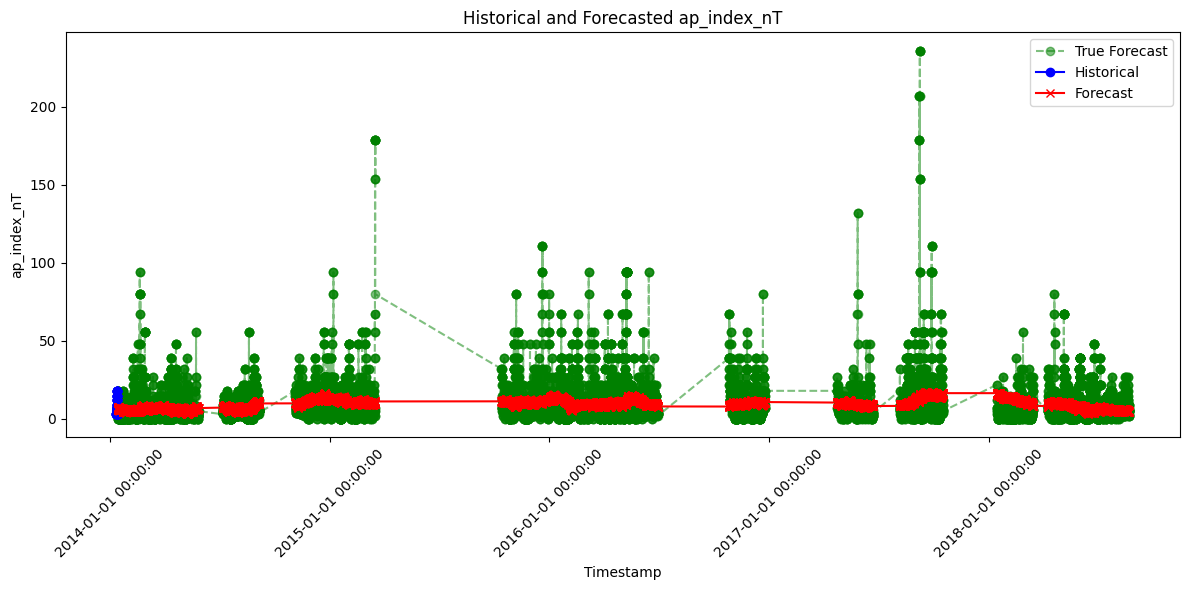

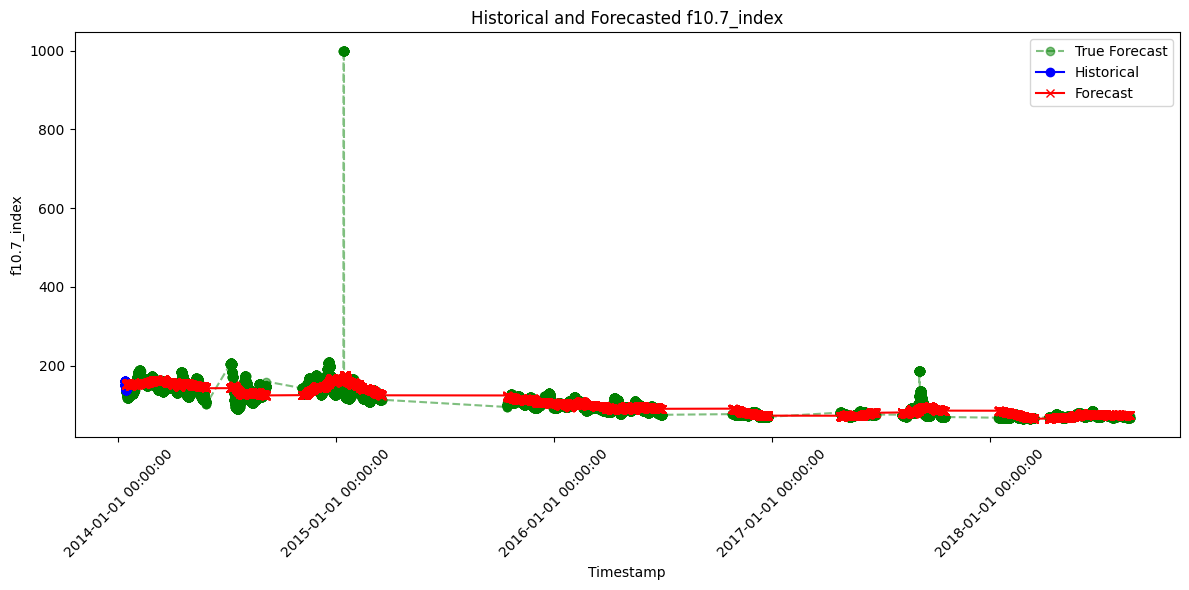

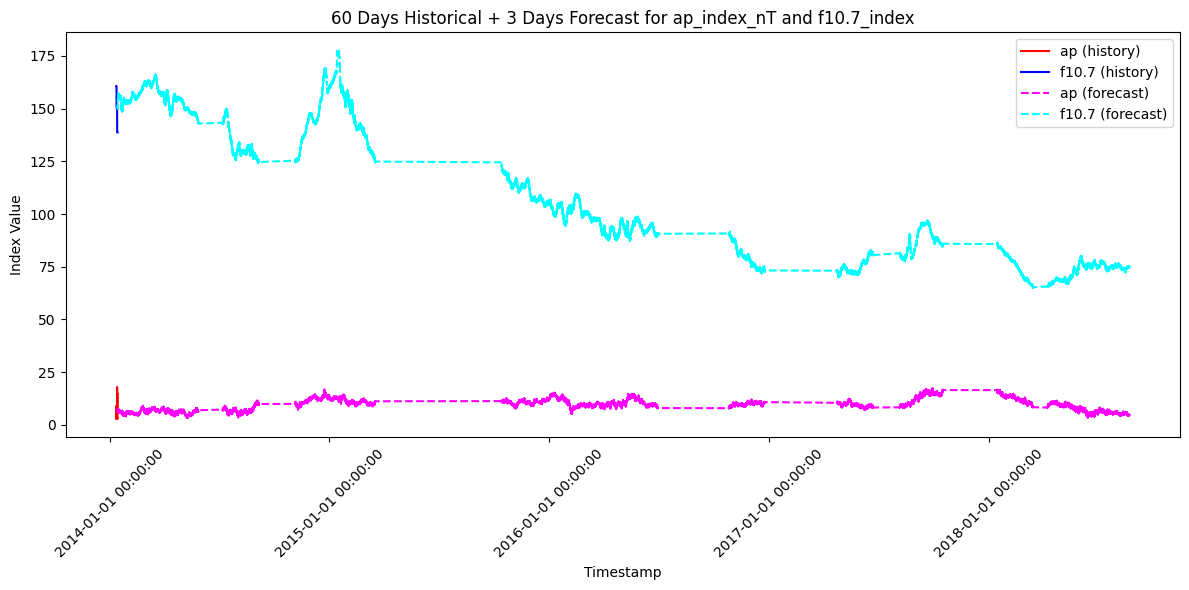

2025-02-15 22:58:23,087 - INFO - Plots generated.


In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_60_days_and_3_day_forecast(
    history_timestamps, history_ap, history_f107,
    forecast_timestamps, forecast_ap, forecast_f107
):
    """
    Plots 60 days of historical data for ap_index_nT (red) and f10.7_index (blue),
    plus 3 days of forecasted data (dashed lines) at satellite-density timestamps.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Plot Historical Data ---
    ax.plot(history_timestamps, history_ap, color='red', label='ap (history)')
    ax.plot(history_timestamps, history_f107, color='blue', label='f10.7 (history)')

    # --- Plot Forecasted Data ---
    ax.plot(forecast_timestamps, forecast_ap, color='magenta', linestyle='--', label='ap (forecast)')
    ax.plot(forecast_timestamps, forecast_f107, color='cyan', linestyle='--', label='f10.7 (forecast)')

    # Format the x-axis to show full date + time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)

    plt.xlabel("Timestamp")
    plt.ylabel("Index Value")
    plt.title("60 Days Historical + 3 Days Forecast for ap_index_nT and f10.7_index")
    plt.legend()
    plt.tight_layout()
    plt.show()

test_offset = split_idx - input_window - forecast_horizon + 1
sample_index = 0  # Choose the first test sample (change as needed)
global_index = test_offset + sample_index
logger.debug(f"Using global index {global_index} for forecast sample.")

history_timestamps = omni_df['Timestamp'].iloc[global_index : global_index + input_window].values
history_ap = omni_df['ap_index_nT'].iloc[global_index : global_index + input_window].values
history_f107 = omni_df['f10.7_index'].iloc[global_index : global_index + input_window].values

forecast_timestamps = omni_df['Timestamp'].iloc[global_index + input_window : global_index + input_window + forecast_horizon].values
true_forecast_ap = omni_df['ap_index_nT'].iloc[global_index + input_window : global_index + input_window + forecast_horizon].values
true_forecast_f107 = omni_df['f10.7_index'].iloc[global_index + input_window : global_index + input_window + forecast_horizon].values

# Run your model to get predictions
sample_x, _ = test_dataset[sample_index]
sample_x = sample_x.unsqueeze(0).to(device)
pred_sample = model(sample_x).cpu().detach().numpy().squeeze(0)
pred_ap = pred_sample[:, 0]
pred_f107 = pred_sample[:, 1]
logger.info("Forecast sample computed.")

# Plot the forecast for ap_index_nT.
plot_combined_forecast(history_timestamps, history_ap, forecast_timestamps, pred_ap,
                       ylabel="ap_index_nT", title="Historical and Forecasted ap_index_nT",
                       true_forecast=true_forecast_ap)

# Plot the forecast for f10.7_index.
plot_combined_forecast(history_timestamps, history_f107, forecast_timestamps, pred_f107,
                       ylabel="f10.7_index", title="Historical and Forecasted f10.7_index",
                       true_forecast=true_forecast_f107)

plot_60_days_and_3_day_forecast(
    history_timestamps, history_ap, history_f107,
    forecast_timestamps, pred_ap, pred_f107
)

logger.info("Plots generated.")

unique_timestamps: ['2000-08-02T04:50:40.000000000' '2000-08-02T05:00:40.000000000'
 '2000-08-02T05:10:40.000000000' '2000-08-02T05:20:40.000000000'
 '2000-08-02T05:30:40.000000000' '2000-08-02T05:40:40.000000000'
 '2000-08-02T05:50:40.000000000' '2000-08-02T06:00:40.000000000'
 '2000-08-02T06:10:40.000000000' '2000-08-02T06:20:40.000000000'
 '2000-08-02T06:30:40.000000000' '2000-08-02T06:40:40.000000000'
 '2000-08-02T06:50:40.000000000' '2000-08-02T07:00:40.000000000'
 '2000-08-02T07:10:40.000000000' '2000-08-02T07:20:40.000000000'
 '2000-08-02T07:30:40.000000000' '2000-08-02T07:40:40.000000000'
 '2000-08-02T07:50:40.000000000' '2000-08-02T08:00:40.000000000'
 '2000-08-02T08:10:40.000000000' '2000-08-02T08:20:40.000000000'
 '2000-08-02T08:30:40.000000000' '2000-08-02T08:40:40.000000000'
 '2000-08-02T08:50:40.000000000' '2000-08-02T09:00:40.000000000'
 '2000-08-02T09:10:40.000000000' '2000-08-02T09:20:40.000000000'
 '2000-08-02T09:30:40.000000000' '2000-08-02T09:40:40.000000000'
 '2000

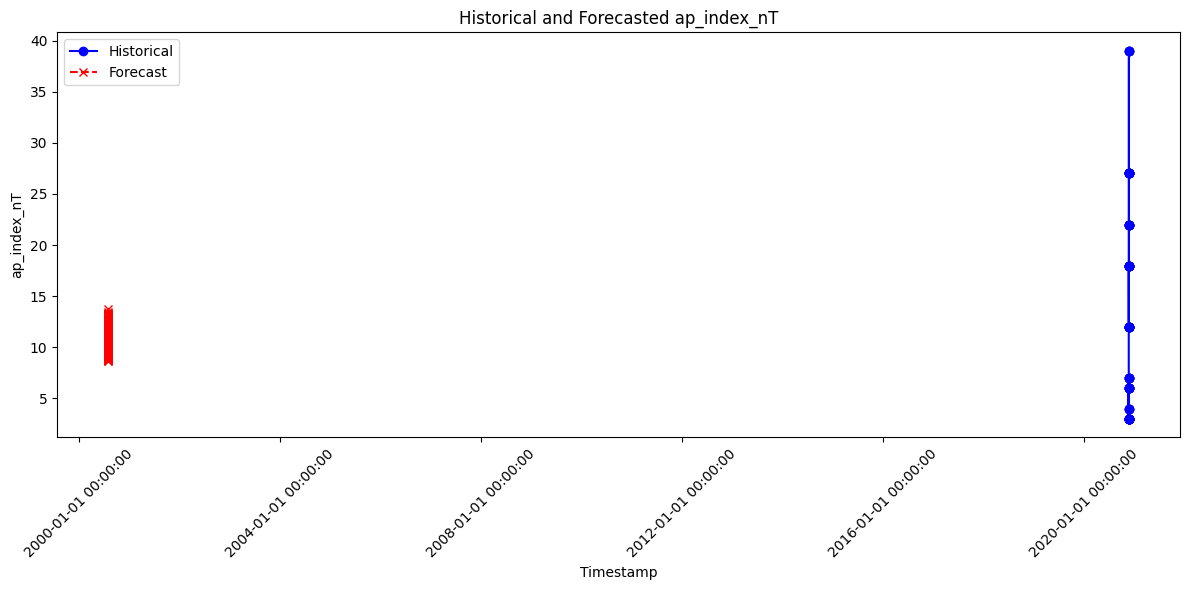

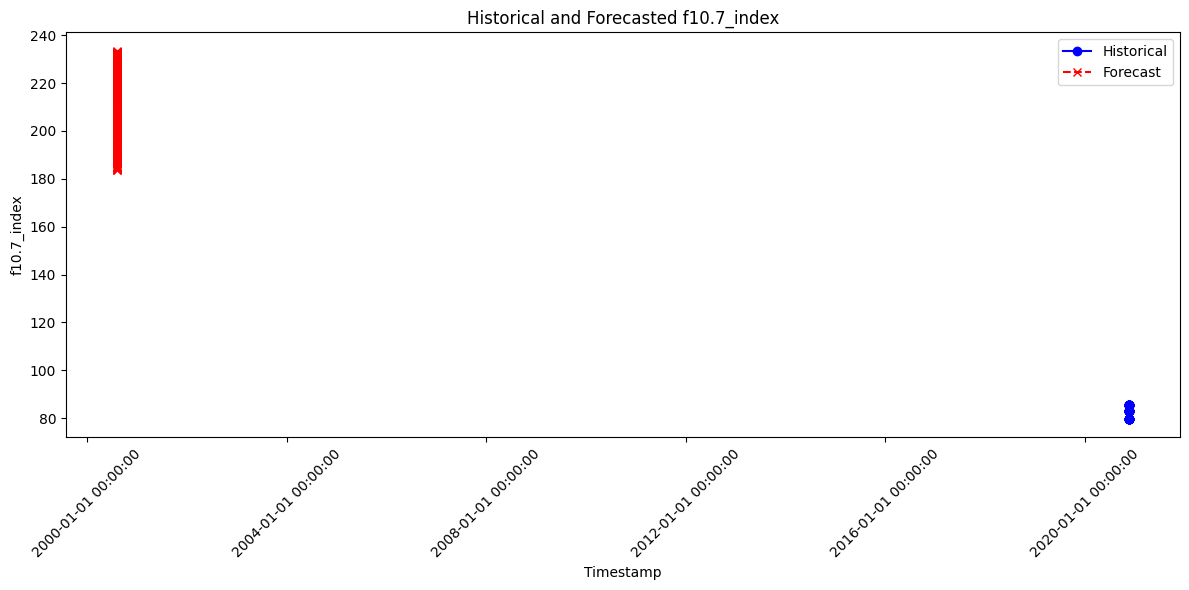

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_forecast_index(history_timestamps, history_values, forecast_timestamps, forecast_values, ylabel, title):
    """
    Plots a time series for a single index: historical values in blue and forecasted values in red.
    
    Args:
        history_timestamps (array-like): Timestamps for the historical data.
        history_values (array-like): Historical values.
        forecast_timestamps (array-like): Timestamps for the forecasted data.
        forecast_values (array-like): Forecasted values.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(history_timestamps, history_values, label="Historical", marker='o', color='blue')
    plt.plot(forecast_timestamps, forecast_values, label="Forecast", marker='x', linestyle="--", color='red')
    plt.xlabel("Timestamp")
    plt.ylabel(ylabel)
    plt.title(title)
    # Format x-axis with full date and time
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def forecast_for_single_file_id(
    model,
    data_handler,
    file_id,
    omni_df,
    X,
    device,
    input_window,
    history_days=60
):
    """
    Forecast for a specific file_id's sat density timestamps while training on all data.
    
    Args:
        model: Trained PatchTST model.
        data_handler: Instance of DataHandler to read sat density files.
        file_id: The specific file ID to forecast.
        omni_df: The entire OMNI DataFrame.
        X: Input features array used for training.
        device: PyTorch device (e.g., 'cuda').
        input_window: Model’s input window size.
        history_days: Number of historical timesteps to display.
    """
    # 1) Load the sat density file for the given file_id.
    try:
        single_sat_density_df = data_handler.read_sat_density_data(file_id)
    except FileNotFoundError:
        raise ValueError(f"Sat density file for File ID {file_id} not found!")
    
    # 2) Sort and extract unique timestamps for this file.
    single_sat_density_df['Timestamp'] = pd.to_datetime(single_sat_density_df['Timestamp'])
    single_sat_density_df.sort_values('Timestamp', inplace=True)
    unique_timestamps = single_sat_density_df["Timestamp"].drop_duplicates().reset_index(drop=True)
    print(f"unique_timestamps: {unique_timestamps.values}")
    forecast_horizon = len(unique_timestamps)
    print(f"Forecast horizon for file ID {file_id} = {forecast_horizon} timestamps.")
    
    # 3) Prepare input sequence using the last 'input_window' points from the entire dataset.
    input_sequence = X[-input_window:]  # shape: (input_window, n_input_features)
    
    # 4) Run the model forecast and slice only the first 'forecast_horizon' steps.
    from_training = model(torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).to(device))
    from_training = from_training.detach().cpu().numpy().squeeze(0)  # (model_forecast_horizon, target_size)
    pred_sample = from_training[:forecast_horizon]
    pred_ap = pred_sample[:, 0]       # Forecast for ap_index_nT.
    pred_f107 = pred_sample[:, 1]     # Forecast for f10.7_index.
    
    # 5) Get the historical data (last 'history_days' points) from omni_df.
    start_index = max(len(omni_df) - history_days, 0)
    history_timestamps = omni_df['Timestamp'].iloc[start_index : start_index + history_days].values
    print(f"history_timestamps: {history_timestamps}")
    history_ap = omni_df['ap_index_nT'].iloc[start_index : start_index + history_days].values
    history_f107 = omni_df['f10.7_index'].iloc[start_index : start_index + history_days].values
    
    # 6) Create two separate plots.
    plot_forecast_index(history_timestamps, history_ap,
                        unique_timestamps.values, pred_ap,
                        ylabel="ap_index_nT", 
                        title="Historical and Forecasted ap_index_nT")
    
    plot_forecast_index(history_timestamps, history_f107,
                        unique_timestamps.values, pred_f107,
                        ylabel="f10.7_index", 
                        title="Historical and Forecasted f10.7_index")

# Example usage:
file_id_to_forecast = 0  # Replace with desired file_id.
forecast_for_single_file_id(
    model=model,
    data_handler=data_handler,
    file_id=file_id_to_forecast,
    omni_df=omni_df,
    X=X,
    device=device,
    input_window=100,    # Same as your model’s input_window.
    history_days=60      # Number of historical timesteps to plot.
)


## Conclusion

In this notebook we:
- Loaded and preprocessed the OMNI and sat density data.
- Selected candidate features based on domain knowledge and cleaned them.
- Defined the PatchTST model and the dataset classes.
- Set up training, evaluation, and forecasting functions.
- (Optionally) Trained the model and evaluated its performance.
- Forecasted on a sample and plotted the historical and forecasted values.

Use the individual cells to debug and experiment without running the entire pipeline every time.
